## Machine Learning Final Project

Using a dataset obtained from Kaggle which includes 4,680 images and labels of handwritten physician scripts, use a variety of classifier approaches to be able to classify these handwritten prescriptions into a common set of Generic Medicine Names or actual Medicine Names. There are 14 Generic Names in the dataset which are mapped from 77 actual Medicine Names. 

The data set was sourced from Kaggle at the following URL - https://www.kaggle.com/datasets/mamun1113/doctors-handwritten-prescription-bd-dataset

This project is submitted by David Betts as the final project for CSCA5622. 

github repo - https://github.com/bettsdr/Intro_to_ML_Supervised.git


In [1]:
# Import the core modules/libraries needed to run the analyses
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib as plt
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
# Establish a data class in which the data will reside
class MedData:
    """
    sets up the dataset to use by loading the Kaggle dataset for Doctor's handwritten prescriptions
    the dataset consists of:
        3120 training samples
        780 testing samples
        780 validation samples
    Each sample consists of a .png image together with a csv file which includes:
        Medicine Name,
        Generic Name, and
        Filename of the image
    
    Because the initial data loading and munging can be time-consuming, the munged data and datasets are written to disk
    when they are first assembled, and loaded only if the munged files are not available on disk
    
    Further, I have constructed the training, testing, and validation samples to have a structure similar to that which we used
    for the MNIST dataset in which the independent datasets (the training, testing and validation datasets) is a
    (n_samples x n_features) array. Each of the features being a single pixel value.
    """
    
    def __init__(self):
        #--------------------------------------
        # A class to import and munge the datasets for training, testing and validation
        # Params: None
        # Attributes:
        #      label_dict - a dictionary containing a mapping of the Generic Names to a numerical value
        #      train_x, train_y, test_x, test_y, val_x, val_y - the training, testing, and validation datasets
        #--------------------------------------
        train_y_file_G = "train_y_g.csv"
        test_y_file_G = "test_y_g.csv"
        val_y_file_G = "val_y_g.csv"
        train_y_file_M = "train_y_m.csv"
        test_y_file_M = "test_y_m.csv"
        val_y_file_M = "val_y_m.csv"
        train_x_file = "train_x.csv"
        test_x_file = "test_x.csv"
        val_x_file = "val_x.csv"
        if os.path.exists(train_y_file_G) and os.path.exists(test_y_file_G) and os.path.exists(val_y_file_G):
            if os.path.exists(train_x_file) and os.path.exists(test_x_file) and os.path.exists(val_x_file):
                if os.path.exists(train_y_file_M) and os.path.exists(test_y_file_M) and os.path.exists(val_y_file_M):
                    load_data = True
                else:
                    load_data = False
            else:
                load_data = False
        else:
            load_data = False
        
        if not load_data:
            print("Building the Data Sets and writing them to files")
            #set up the location of the csv files with the labeling information
            test_file = "./Testing/testing_labels.csv"
            training_file = "./Training/training_labels.csv"
            validation_file = "./Validation/validation_labels.csv"

            # load the images from the disk using the get_images() method
            test_images, train_images, val_images, test_names, train_names, val_names = self.get_images()

            # scale the images to all be the same size using the scale_images_to_sama_size(images) method

            test_images = self.scale_images_to_same_size(test_images)
            train_images = self.scale_images_to_same_size(train_images)
            val_images = self.scale_images_to_same_size(val_images)

            # load the csv files with the labels into a pandas dataframe
            df_testing = pd.read_csv(test_file)
            df_training = pd.read_csv(training_file)
            df_validation = pd.read_csv(validation_file)

            # create a dictionary of the Generic Names to use as labels with the create_labels method 
            self.label_dict_G = {}
            self.label_dict_G = self.create_labels(df_testing, self.label_dict_G, "G")
            self.label_dict_G = self.create_labels(df_training, self.label_dict_G, "G")
            self.label_dict_G = self.create_labels(df_validation, self.label_dict_G, "G")
            
            # create a dictionary of the Medicine Names to use as labels with the create_labels method 
            self.label_dict_M = {}
            self.label_dict_M = self.create_labels(df_testing, self.label_dict_M, "M")
            self.label_dict_M = self.create_labels(df_training, self.label_dict_M, "M")
            self.label_dict_M = self.create_labels(df_validation, self.label_dict_M, "M")

            # fill out the dataframes by adding the images using the fill_out_df(df, names, images) method
            df_testing = self.fill_out_df(df_testing, test_names, test_images)
            df_training = self.fill_out_df(df_training, train_names, train_images)
            df_validation = self.fill_out_df(df_validation, val_names, val_images)

            # create the labels column in the dataframes by using the lookup into the label_dict dictionarys
            df_testing['Glabel'] = df_testing.GENERIC_NAME.apply(lambda x: self.label_dict_G[x])
            df_training['Glabel'] = df_training.GENERIC_NAME.apply(lambda x: self.label_dict_G[x])
            df_validation['Glabel'] = df_validation.GENERIC_NAME.apply(lambda x: self.label_dict_G[x])
            df_testing['Mlabel'] = df_testing.MEDICINE_NAME.apply(lambda x: self.label_dict_M[x])
            df_training['Mlabel'] = df_training.MEDICINE_NAME.apply(lambda x: self.label_dict_M[x])
            df_validation['Mlabel'] = df_validation.MEDICINE_NAME.apply(lambda x: self.label_dict_M[x])

            # convert the flatimages column of the dataframes to a set of columns each representing a single pixel
            # of the image for all 12,000 pixels. These will become the testing, training, and validation datasets.
            # This uses the convert_images(df) method
            self.test_x = self.convert_images(df_testing)
            self.train_x = self.convert_images(df_training)
            self.val_x = self.convert_images(df_validation)

            # creates the datasets for y 
            self.train_y_g = df_training["Glabel"].values
            self.test_y_g = df_testing["Glabel"].values
            self.val_y_g = df_validation["Glabel"].values
            self.train_y_m = df_training["Mlabel"].values
            self.test_y_m = df_testing["Mlabel"].values
            self.val_y_m = df_validation["Mlabel"].values
            
            # saves datasets and labels to the disk for future loading
            train_y_g = pd.DataFrame(self.train_y_g)
            test_y_g = pd.DataFrame(self.test_y_g)
            val_y_g = pd.DataFrame(self.val_y_g)
            train_y_m = pd.DataFrame(self.train_y_m)
            test_y_m = pd.DataFrame(self.test_y_m)
            val_y_m = pd.DataFrame(self.val_y_m)
            
            train_y_g.to_csv("train_y_g.csv", sep = ',', index = False, encoding = 'utf-8')
            test_y_g.to_csv("test_y_g.csv", sep = ',', index = False, encoding = 'utf-8')
            val_y_g.to_csv("val_y_g.csv", sep = ',', index = False, encoding = 'utf-8')
            train_y_m.to_csv("train_y_m.csv", sep = ',', index = False, encoding = 'utf-8')
            test_y_m.to_csv("test_y_m.csv", sep = ',', index = False, encoding = 'utf-8')
            val_y_m.to_csv("val_y_m.csv", sep = ',', index = False, encoding = 'utf-8')
            self.train_x.to_csv("train_x.csv", sep = ',', index = False, encoding = 'utf-8')
            self.test_x.to_csv("test_x.csv", sep = ',', index = False, encoding = 'utf-8')
            self.val_x.to_csv("val_x.csv", sep = ',', index = False, encoding = 'utf-8')
            
        else:
            print("Loading the datasets from disk")
            test_file = "./Testing/testing_labels.csv"
            training_file = "./Training/training_labels.csv"
            validation_file = "./Validation/validation_labels.csv"
            self.train_y_g = (pd.read_csv("train_y_g.csv").to_numpy()).reshape(-1,1).squeeze()
            self.test_y_g = (pd.read_csv("test_y_g.csv").to_numpy()).reshape(-1,1).squeeze()
            self.val_y_g = pd.read_csv("val_y_g.csv").to_numpy().reshape(-1,1).squeeze()
            self.train_y_m = (pd.read_csv("train_y_m.csv").to_numpy()).reshape(-1,1).squeeze()
            self.test_y_m = (pd.read_csv("test_y_m.csv").to_numpy()).reshape(-1,1).squeeze()
            self.val_y_m = pd.read_csv("val_y_m.csv").to_numpy().reshape(-1,1).squeeze()
            self.train_x = pd.read_csv("train_x.csv").to_numpy()
            self.test_x = pd.read_csv("test_x.csv").to_numpy()
            self.val_x = pd.read_csv("val_x.csv").to_numpy()
            df_testing = pd.read_csv(test_file)
            df_training = pd.read_csv(training_file)
            df_validation = pd.read_csv(validation_file)
            self.label_dict_G = {}
            self.label_dict_G = self.create_labels(df_testing, self.label_dict_G, "G")
            self.label_dict_G = self.create_labels(df_training, self.label_dict_G, "G")
            self.label_dict_G = self.create_labels(df_validation, self.label_dict_G, "G")
            self.label_dict_M = {}
            self.label_dict_M = self.create_labels(df_testing, self.label_dict_M, "M")
            self.label_dict_M = self.create_labels(df_training, self.label_dict_M, "M")
            self.label_dict_M = self.create_labels(df_validation, self.label_dict_M, "M")
            
        
        
    def create_labels(self, df, label_dict, switch):
        # creates the label_dict variable for the datasets which is a dictionary that maps the Generic Name or the Medicine Name
        # of medications to a numerical value
        # params:
        #      df - the dataframe from which to extract any GenericName or MedicineName value for mapping
        #      label_dict - the current label_dict being used
        #      switch - to tell this function whether to create labels for Generic Names ("G") or Medicine Names ("M")
        # returns: an updated label_dict dictionary
        if switch == "G":
            column = "GENERIC_NAME"
        else:
            column = "MEDICINE_NAME"
        gen_names = df[column].to_list()
        list_names = []
        for each in gen_names:
            if each not in list_names:
                list_names.append(each)
        if len(label_dict.keys()) == 0:
            index = 0
        else:
            index = len(label_dict.keys()) + 1
        for each in list_names:
            if each not in label_dict:
                label_dict[each] = index
                index += 1
        return label_dict
    
    def get_images(self):
        #adds the actual image files to variables for later storage in the dataframes for additional munging
        # params: NONE
        # returns:
        #        test_images, train_images, val_images, test_names, train_names, val_names
        # all of the return variables *_images are lists containing the numerical data of the underlying images
        # and the *_names variables are lists containing the filenames of the images themselves in case we need
        # perform a sanity check later
        
        test_path = "./Testing/testing_words/"
        training_path = "./Training/training_words/"
        validation_path = "./Validation/validation_words/"
        test_images = []
        train_images = []
        val_images = []
        test_names = []
        train_names = []
        val_names = []
        for i in range(3120):
            train_names.append(str(i) + ".png")
            training_filename = training_path + str(i) + ".png"
            if i < 780:
                test_filename = test_path + str(i) + ".png"
                test_img = cv2.imread(test_filename, 0)
                validation_filename = validation_path + str(i) + ".png"
                validation_img = cv2.imread(validation_filename, 0)
                
                test_images.append(test_img)
                val_images.append(validation_img)
                test_names.append(str(i) + ".png")
                val_names.append(str(i) + ".png")
            training_img = cv2.imread(training_filename, 0)
            train_images.append(training_img)        
        
        return test_images, train_images, val_images, test_names, train_names, val_names

    def fill_out_df(self, df, imagenames, images):
        # adds three columns to an existing dataframe which contain the image names, the images themselves, and
        # a flattened version of the images accordingly
        # params:
        #      df - the dataframe to augment
        #      imagenames - a list of the image names
        #      images - a list that holds the images themselves
        # returns the augmented dataframe
        
        df["imagename"] = imagenames
        flattened_images = []
        for i in range(len(images)):
            flattened_images.append(images[i].flatten())
        df["images_full"] = images
        df["flatimages"] = flattened_images
        return df
    
    def get_image_sizes(self, images):
        # this was a helper function used in the initial munging to assess the size of the images in the underlying dataset
        # this isn't used directly in the class anymore, but was useful to determine how to resize the images to standardize
        # the images to a common size
        # params: 
        #      images - a list of the images to assess
        # action: prints out the average height and width, the max height and width, and the min height and width
        # returns: Nothing
        
        heights = []
        widths = []
        for img in images:
            h, w = img.shape[:2]
            heights.append(h)
            widths.append(w)
        print(f'the average height is {sum(heights)/len(heights)}')
        print(f'the average width is {sum(widths) / len(widths)}')
        print(f'the max height is {max(heights)}')
        print(f'the max width is {max(widths)}')
        print(f'the min height is {min(heights)}')
        print(f'the min width is {min(widths)}')
        return
    
    def scale_images_to_same_size(self, images):
        # resizes the images in a list to a common size that was determined previously and is hard-coded here to 200x60
        # params:
        #      images - a list of images to resize
        # action: uses the opencv library .resize() method to resize the images to a common size
        # returns: a new list of the images standardized by size
        
        width_max = 200
        height_max = 60
        imgs_scaled = []
        for img in images:
            h, w = img.shape[:2]
            new_img = cv2.resize(img, (width_max, height_max))
            imgs_scaled.append(new_img)
        return imgs_scaled

    def convert_images(self, df):
        # converts the image data from a list of pixels using the data stored in the dataframe['flatimages'] column to a
        # new dataframe which contains columns labeled for each pixel stored in the lists under the 'flatimages' column
        # params:
        #      df - the dataframe from which to extract the image data
        # returns:
        #      new_df - the dataframe containing only the pixel columns for each row of the original df
        
        from operator import itemgetter
        indices = range(12000)
        new_df= df['flatimages'].transform({f'pixel{i}': itemgetter(i) for i in indices})
        return new_df
    
    def get_generic_name(self, key):
        # provides the label name from the label_dict given a numerical value of the label
        # params:
        #      key - a numerical value from the dataset
        # returns:
        #      the English label provided in the original dataset for GENERIC_NAME
        
        return list(self.label_dict_G.keys())[list(self.label_dict_G.values()).index(key)]
    
    def get_medicine_name(self, key):
        # provides the label name from the label_dict given a numerical value of the label
        # params:
        #      key - a numerical value from the dataset
        # returns:
        #      the English label provided in the original dataset for GENERIC_NAME
        
        return list(self.label_dict_M.keys())[list(self.label_dict_M.values()).index(key)]
        
     
            

# Load the Data

We will first load the data into the variable data which will include three datasets containing the training samples, the testing samples and the validation samples. We will also create three corresponding datasets for the labels.

The MedData Class loads the data from the associated folders and creates the data sets. Once the data sets are created locally, it writes them to disk to facilitate more efficient data loading after the first time that the data sets are created. 

In [3]:
# runs the MedData Constructor to create a data object with the datasets required for analysis and prints out the shape of each
data = MedData()
print(f'the shape of the testing data {data.test_x.shape}')
print(f'the shape of the testing labels for generic names {data.test_y_g.shape}')
print(f'the shape of the testing labels for medicine names {data.test_y_m.shape}')
print(f'the shape of the training data {data.train_x.shape}')
print(f'the shape of the training labels for generic names {data.train_y_g.shape}')
print(f'the shape of the training labels for medicine names {data.train_y_m.shape}')
print(f'the shape of the validation data {data.val_x.shape}')
print(f'the shape of the validation labels for generic names {data.val_y_g.shape}')
print(f'the shape of the validation labels for medicine names {data.val_y_m.shape}')


Loading the datasets from disk
the shape of the testing data (780, 12000)
the shape of the testing labels for generic names (780,)
the shape of the testing labels for medicine names (780,)
the shape of the training data (3120, 12000)
the shape of the training labels for generic names (3120,)
the shape of the training labels for medicine names (3120,)
the shape of the validation data (780, 12000)
the shape of the validation labels for generic names (780,)
the shape of the validation labels for medicine names (780,)


In [4]:
# a function to view the image of a handwritten script given a particular sample and, optionally, it's label
def view_script(x, label=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(x.reshape(60,200), cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("true: {}".format(label), fontsize=16)

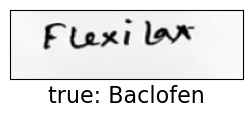

In [37]:
# picks a random number from the range of the training data to show the image of the script given a sample
# uses the view_script() function above
import random
script_index = random.randint(0,data.train_x.shape[0])
x = data.train_x[script_index]
y = data.get_generic_name(data.train_y_g[script_index])
view_script(x,y)

## Classification with K-Nearest Neighbors

In [6]:
# a class from the earlier lab work for k-nearest neighbors, lifted directly from the lab module itself without modification.
class HomeWork_KNN:
    
    """
    Class to store data for regression problems 
    """
    def __init__(self, x_train, y_train, K=5):
        """
        Creates a kNN instance

        :param x_train: numpy array with shape (n_rows,1)- e.g. [[1,2],[3,4]]
        :param y_train: numpy array with shape (n_rows,)- e.g. [1,-1]
        :param K: The number of nearest points to consider in classification
        """

        # Import and build the BallTree on training features 
        from sklearn.neighbors import BallTree
        self.balltree = BallTree(x_train)

        # Cache training labels and parameter K 
        self.y_train = y_train
        self.K = K 


    def majority(self, neighbor_indices, neighbor_distances=None):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param neighbor_indices: The indices of the K nearest neighbors in self.X_train 
        :param neighbor_distances: Corresponding distances from query point to K nearest neighbors. 
        """

        # your code here
        result = {}
        for each in neighbor_indices[0]:
            if self.y_train[each] not in result:
                result[self.y_train[each]] = 1
            else:
                result[self.y_train[each]] += 1
        return result



    def classify(self, x):
        """
        Given a query point, return the predicted label 

        :param x: a query point stored as an ndarray  
        """
        # your code here

        #result = [0 for _ in range(10)]
        sample = x.reshape(1,-1)
        return_indices = self.balltree.query(sample, self.K, return_distance = False)
        #print(f'return indices are: {return_indices}')
        result_dict = self.majority(return_indices)
        result = [key for m in [max(result_dict.values())] for key,val in result_dict.items() if val == m]
        k = self.K
        #print(f'result is {result}')
        while len(result) > 1:
            #print('need to break a tie')
            k -= 1
            return_indices = self.balltree.query(sample, k, return_distance = False)
            #print(f'return_indices is now: {return_indices}')
            result_dict = self.majority(return_indices)
            result = [key for m in [max(result_dict.values())] for key,val in result_dict.items() if val == m]
            #print(f'result is now {result}')
        #idx = result.index(max(result))
        return result[0]



    def predict(self, X):
        """
        Given an ndarray of query points, return yhat, an ndarray of predictions 

        :param X: an (m x p) dimension ndarray of points to predict labels for 
        """
        # your code here
        yhat = []
        for each in X:
            yhat.append(self.classify(each))
        return yhat

In [7]:
# create a HomeWork_knn object for analysis
knn = HomeWork_KNN(data.train_x, data.train_y_g, K=7)

# determine the training error from the knn object by running the predict function on the training data. Place the result in
# a new object called yhat
yhat = knn.predict(data.train_x)

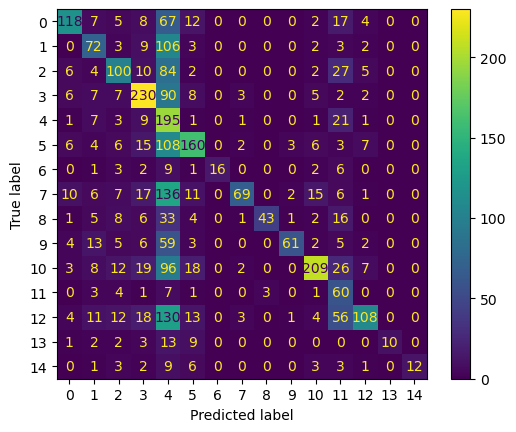

In [8]:
C = sk.metrics.confusion_matrix(data.train_y_g, yhat)
disp = sk.metrics.ConfusionMatrixDisplay(C, display_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14"])
#disp = sk.metrics.ConfusionMatrixDisplay.from_predictions(truth, validate, display_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"], values_format = 'd', colorbar = False)
disp.plot()
plt.show()

In looking at the result of the k-nearest neighbors prediction on the training data, there appear to be a few of the generic medicine names which are relatively easily confused. These are label #12 which is frequently misclassified as many of the other labels. Interestingly, the model also seems to predict label #4 quite frequently incorrectly for most of the actual images. 

Looking a bit more closely at this, label #12 corresponds to the Generic Name of Montelukast Sodium and #4 corresponds to Azithromycin Dihydrate. 

The cell below looks at the Confusion Matrix for the classification of the test data. These are samples that the model has not yet seen.

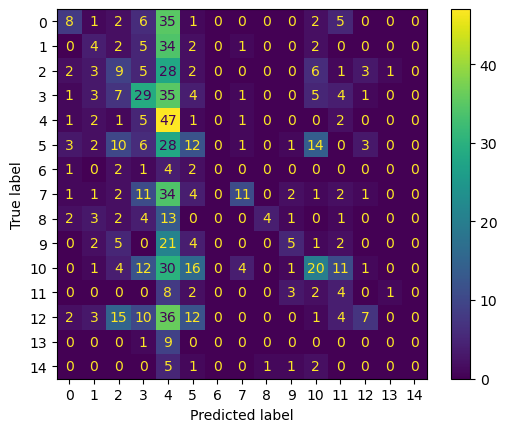

In [10]:
yhat = knn.predict(data.test_x)
C = sk.metrics.confusion_matrix(data.test_y_g, yhat)
disp = sk.metrics.ConfusionMatrixDisplay(C, display_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14"])
disp.plot()
plt.show()

Similarly to the training data, the test data performs relatively poorly on the k-nearest neighbor analysis with the model frequently predicting that the data are associated with label #4, Azithromycin Dihydrate.

I will now run the model for multiple values of k and assess accuracy, similarly to what we did in Week 4 lab.

**WARNING THIS WILL TAKE A VERY LONG TIME TO RUN**

[0.3192307692307692, 0.2705128205128205, 0.23846153846153847, 0.20384615384615384, 0.1987179487179487]


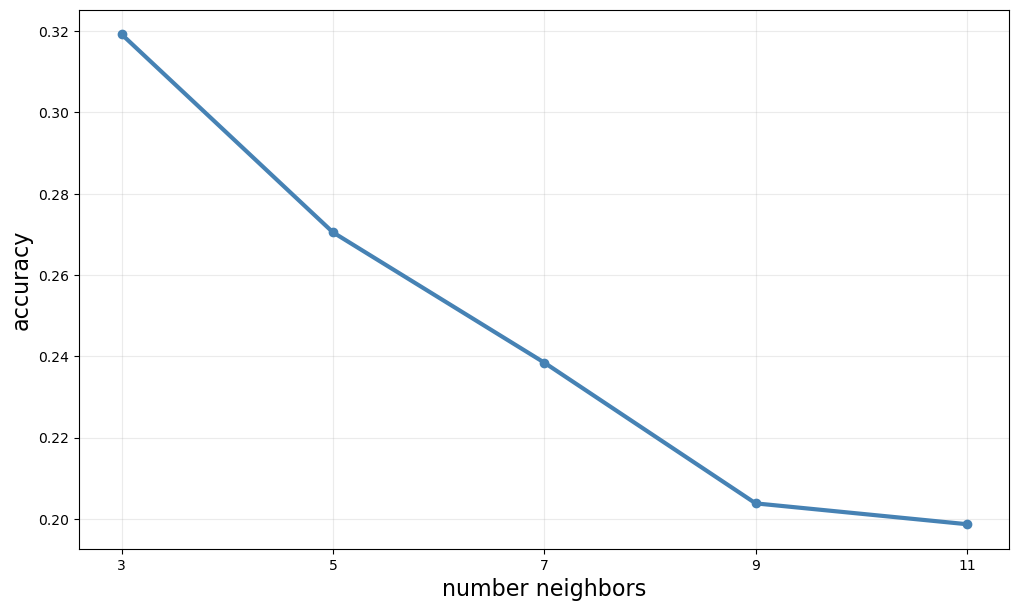

In [11]:
acc = []
allks = range(3,13,2)

# your code here
truth = data.val_y_g
for each in allks:
    knn = HomeWork_KNN(data.train_x, data.train_y_g, K=each)
    validate = knn.predict(data.val_x)
    acc.append(sk.metrics.accuracy_score(truth, validate))
print(acc)    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.xticks(range(3,13,2))
ax.grid(alpha=0.25)

Overall, the k-nearest neighbors approach to classification on this data performs relatively poorly. While better at predicting based on fewer neighbors, the best performance we achieve is just over 31% accuracy using Generic Names for medicines. 

I am going to now re-run the similar analyses using the actual Medicine Names that are in the dataset as well to see if it performs better on those.

In [12]:
# create a HomeWork_knn object for analysis
knn = HomeWork_KNN(data.train_x, data.train_y_m, K=7)

# determine the training error from the knn object by running the predict function on the training data. Place the result in
# a new object called yhat
yhat = knn.predict(data.train_x)

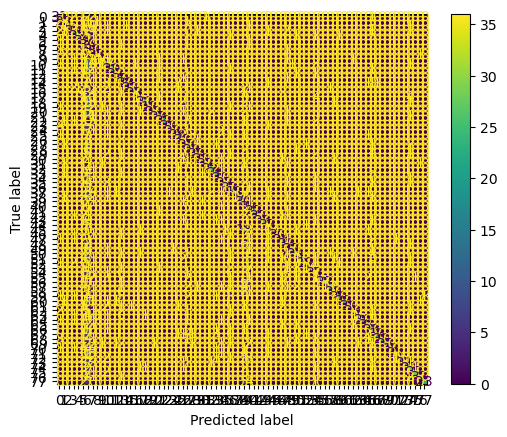

In [13]:
C = sk.metrics.confusion_matrix(data.train_y_m, yhat)
disp = sk.metrics.ConfusionMatrixDisplay(C, display_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14",
                                                             "15", "16", "17", "18","19","20","21","22","23","24","25","26","27","28","29",
                                                             "30","31","32","33","34","35","36","37","38","39","40","41","42","43","44","45",
                                                             "46","47","48","49","50","51","52","53","54","55","56","57","58","59","60","61",
                                                             "62","63","64","65","66","67","68","69","70","71","72","73","74","75","76","77"])
disp.plot()
plt.show()

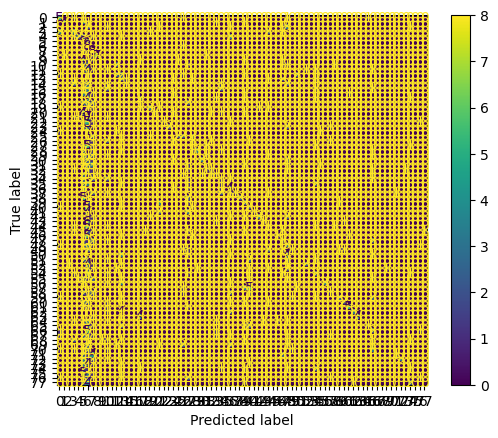

In [14]:
yhat = knn.predict(data.test_x)
C = sk.metrics.confusion_matrix(data.test_y_m, yhat)
disp = sk.metrics.ConfusionMatrixDisplay(C, display_labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14",
                                                             "15", "16", "17", "18","19","20","21","22","23","24","25","26","27","28","29",
                                                             "30","31","32","33","34","35","36","37","38","39","40","41","42","43","44","45",
                                                             "46","47","48","49","50","51","52","53","54","55","56","57","58","59","60","61",
                                                             "62","63","64","65","66","67","68","69","70","71","72","73","74","75","76","77"])
disp.plot()
plt.show()

[0.2833333333333333, 0.25, 0.22564102564102564, 0.2012820512820513, 0.18974358974358974]


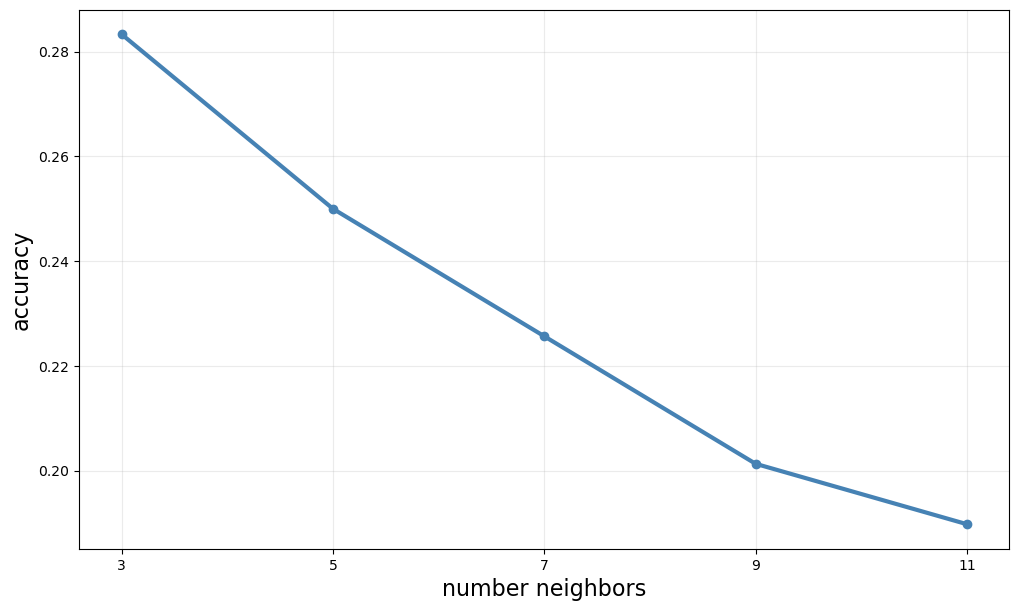

In [15]:
acc = []
allks = range(3,13,2)

# your code here
truth = data.val_y_m
for each in allks:
    knn = HomeWork_KNN(data.train_x, data.train_y_m, K=each)
    validate = knn.predict(data.val_x)
    acc.append(sk.metrics.accuracy_score(truth, validate))
print(acc)    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.xticks(range(3,13,2))
ax.grid(alpha=0.25)

## Decision Tree Model Assessment

Given the relatively poor performance of the k-nearest neighbors models, this section will undertake to do the multi-classification problem using a decision tree approach. This first section will explore an unbounded Decision Tree model (i.e. a Decision Tree which is built without any pruning or max_depth or min_samples_leaf settings).

In [16]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(data.train_x, data.train_y_g)


DecisionTreeClassifier()

In [17]:
#calculate and show the accuracy scores for the training, testing and validation samples given the full tree
yhat_train = tree.predict(data.train_x)
yhat_test = tree.predict(data.test_x)
yhat_val = tree.predict(data.val_x)
y_true_train = data.train_y_g
y_true_test = data.test_y_g
y_true_val = data.val_y_g
acc_train = sk.metrics.accuracy_score(y_true_train, yhat_train)
acc_test = sk.metrics.accuracy_score(y_true_test, yhat_test)
acc_val = sk.metrics.accuracy_score(y_true_val, yhat_val)
print(f'accuracy of the Decision Tree on the Training Data is: {acc_train}')
print(f'accuracy of the Decision Tree on the Test Data is: {acc_test}')
print(f'accuracy of the Decision Tree on the Validation Data is: {acc_val}')
print(f'the depth of the current classifier tree is {tree.get_depth()}')

accuracy of the Decision Tree on the Training Data is: 1.0
accuracy of the Decision Tree on the Test Data is: 0.18205128205128204
accuracy of the Decision Tree on the Validation Data is: 0.2602564102564103
the depth of the current classifier tree is 36


Somewhat as expected, the full Desision Tree overfits the training data resulting in a model that does very poorly on the testing and validation data. To address this overfitting, the model should be fit with a shallower depth constraint, a larger minimum number of samples per leaf or with come cost-complexity pruning.

In [18]:
#creating a shallower DecisionTree to reduce overfitting and hopefully improve the generalized performance of the Decision Tree
shallow_tree = DecisionTreeClassifier(max_depth=10)
shallow_tree.fit(data.train_x, data.train_y_g)
yhat_train = shallow_tree.predict(data.train_x)
yhat_test = shallow_tree.predict(data.test_x)
yhat_val = shallow_tree.predict(data.val_x)
acc_train = sk.metrics.accuracy_score(y_true_train, yhat_train)
acc_test = sk.metrics.accuracy_score(y_true_test, yhat_test)
acc_val = sk.metrics.accuracy_score(y_true_val, yhat_val)
print(f'accuracy of the Decision Tree on the Training Data is: {acc_train}')
print(f'accuracy of the Decision Tree on the Test Data is: {acc_test}')
print(f'accuracy of the Decision Tree on the Validation Data is: {acc_val}')
print(f'the depth of the current classifier tree is {shallow_tree.get_depth()}')

accuracy of the Decision Tree on the Training Data is: 0.49935897435897436
accuracy of the Decision Tree on the Test Data is: 0.13846153846153847
accuracy of the Decision Tree on the Validation Data is: 0.24743589743589745
the depth of the current classifier tree is 10


Interestingly, reducing the depth to 10, while it reduces the training accuracy (as expected), does not improve the performance overall on the testing or validation data. 

In [19]:
#creating a DecisionTree with larger leaves to reduce overfitting and hopefully improve the generalized performance
# of the Decision Tree

larger_leaf_tree = DecisionTreeClassifier(min_samples_leaf=10)
larger_leaf_tree.fit(data.train_x, data.train_y_g)
yhat_train = shallow_tree.predict(data.train_x)
yhat_test = shallow_tree.predict(data.test_x)
yhat_val = shallow_tree.predict(data.val_x)
acc_train = sk.metrics.accuracy_score(y_true_train, yhat_train)
acc_test = sk.metrics.accuracy_score(y_true_test, yhat_test)
acc_val = sk.metrics.accuracy_score(y_true_val, yhat_val)
print(f'accuracy of the Decision Tree on the Training Data is: {acc_train}')
print(f'accuracy of the Decision Tree on the Test Data is: {acc_test}')
print(f'accuracy of the Decision Tree on the Validation Data is: {acc_val}')
print(f'the depth of the current classifier tree is {larger_leaf_tree.get_depth()}')

accuracy of the Decision Tree on the Training Data is: 0.49935897435897436
accuracy of the Decision Tree on the Test Data is: 0.13846153846153847
accuracy of the Decision Tree on the Validation Data is: 0.24743589743589745
the depth of the current classifier tree is 25


Similarly, increasing the minimum samples per leaf and allowing the depth to increase also does not improve overall performance

Given this, we will look at the results of pruning the trees using cost-complexity pruning. Given the complexity of decison tree driven by the inclusion of 12,000 features in each sample, there are 709 ccp_alphas to evaluate. It took approximately 2 hours to plot the accuracy results for all values of ccp_alpha. As a result, this will evaluate only every 100th which will reduce the amount of time to run in the notebook. I have commented below the lines that will run all 709 classifiers, if you'd like to see the full results.

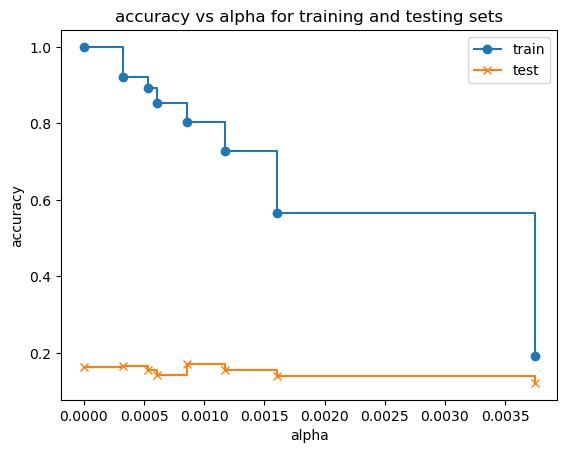

In [23]:
path = tree.cost_complexity_pruning_path(data.train_x, data.train_y_g) #post pruning
ccp_alphas, impurities = path.ccp_alphas, path.impurities
#print(f'the model will evaluate {len(ccp_alphas)} classifiers so will take a very long time to process')

clfs = [] # VECTOR CONTAINING CLASSIFIERS FOR DIFFERENT ALPHAS
ccp_value = []
iteration = 0
for each in ccp_alphas:
    #print(f'fitting iteration #{iteration}')
    if iteration % 100 == 0:
        clf = DecisionTreeClassifier(ccp_alpha=each)
        clf.fit(data.train_x, data.train_y_g)
        clfs.append(clf)
        ccp_value.append(each)
        #print(f'iteration # {iteration + 1} - {100 * (iteration + 1) / len(ccp_alphas)}% complete with model creation')
    iteration += 1

#print("Moving on to evaluate the performance of the {len(ccp_alphas)} models")
train_scores = []
test_scores = []
iteration = 0
for each in clfs:
    #print(f'performing accuracy assessment for model #{iteration}')
    yhat_train = each.predict(data.train_x)
    train_scores.append(sk.metrics.accuracy_score(y_true_train, yhat_train))
    yhat_test = each.predict(data.test_x)
    test_scores.append(sk.metrics.accuracy_score(y_true_test, yhat_test))
    #print(f'iteration # {iteration + 1} - {100 * (iteration + 1) / len(clfs)}% complete with model evaluation')
    iteration += 1
    
          
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs alpha for training and testing sets")
ax.plot(ccp_value, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_value, test_scores, marker='x', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show() 


As the graph above shows, performance of the decision tree overall drops off pretty dramatically on the training data set as the tree is pruned. And, when presented with the testing data set, observations that have not been seen by the model at all in training, the performance is pretty poor. Even pruning the tree to reduce overfitting on the training data does not improve its performance at all on the testing data set.

Given this overall performance with Decision Trees and with k-nearest neighbors, it is clear that this data is not easily classified using these techniques. While I could ensemble the decision trees, given the complexity of the underlying data, I am not sure that a Random Forest or Boosting option would markedly increase overall performance with these models.

I will now try to apply a Support Vector Machine on this multi-class classification project below. Given the performance thus far, I do not have a lot of confidence that this will perform much better prior to running this analysis. Given the complexity of this data, I can imagine that it is not linearly separable, so I will choose to create a model using a radial-basis function kernel. 



## Support Vector Machine

In [24]:

svm = sk.svm.SVC()
svm.fit(data.train_x, data.train_y_g)
yhat_train = svm.predict(data.train_x)
yhat_test = svm.predict(data.test_x)
yhat_val = svm.predict(data.val_x)
acc_train = sk.metrics.accuracy_score(y_true_train, yhat_train)
acc_test = sk.metrics.accuracy_score(y_true_test, yhat_test)
acc_val = sk.metrics.accuracy_score(y_true_val, yhat_val)

print(f'accuracy of the SVM on the Training Data is: {acc_train}')
print(f'accuracy of the SVM on the Test Data is: {acc_test}')
print(f'accuracy of the SVM on the Validation Data is: {acc_val}')

accuracy of the SVM on the Training Data is: 0.8727564102564103
accuracy of the SVM on the Test Data is: 0.32051282051282054
accuracy of the SVM on the Validation Data is: 0.39871794871794874


Interestingly, the approach using a support vector machine with the RBF kernel achieved the best results thus far. While I am encouraged that we got 32% and 39% respectively on the testing and validation data classifications, I can imagine that tuning the parameters for C and for gamma could perhaps lead to better performance.

Tuning the parameters of the support vector machine approach might give improved performance given the relatively stronger performance on the initial pass of the model. The cell below runs a grid search, similar to what we did in Module 6 of the course labs, to assess k-fold cross-validation accuracy on the 9 models ranging the C and gamma parameters logarithmically between 2^-5 and 2^5. 

(Note: I tried to run this initially with a 50 x 50 grid search, but after allowing it to run for ~24 hours on a 24-core processor system, I estimate that it would take approximately 420 hours to do so on a relatively high-powered machine. This is going to run with 9 which will take approximately 90 minutes to complete)

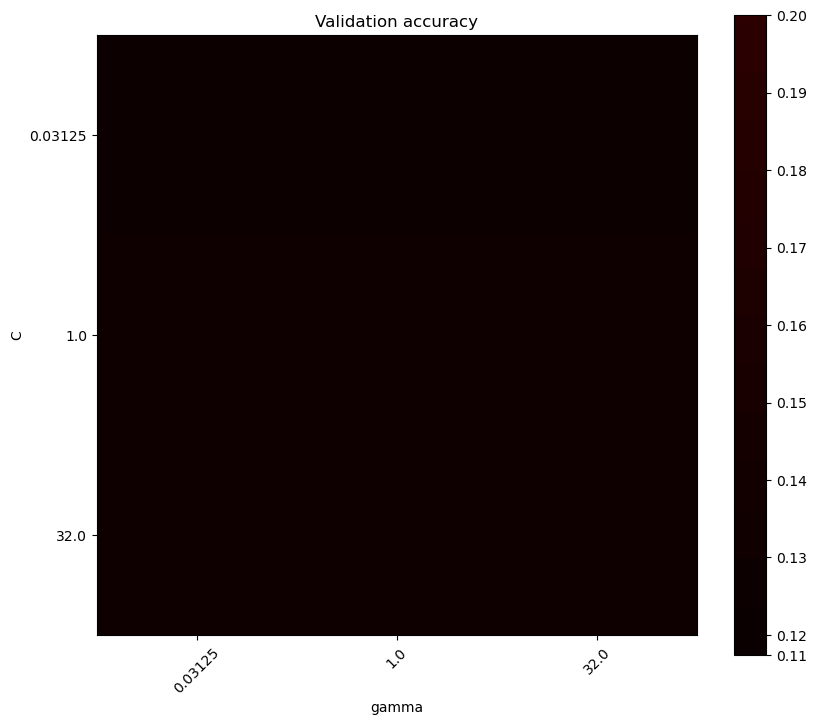

In [28]:
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import Normalize
import multiprocessing

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()
    return

test_range = np.logspace(-5,5,base = 2, num = 3, dtype='float',endpoint=True)
parameters = {"C":test_range,"gamma":test_range}
grid = GridSearchCV(svm, parameters, cv = 3, n_jobs = -1)
grid.fit(data.train_x, data.train_y_g)
plotSearchGrid(grid)


In [29]:
# print out the scores in a two by two grid given the graph of the results is not overly helpful
scores = [x for x in grid.cv_results_["mean_test_score"]]
scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))
print(scores)

[[0.12820513 0.12820513 0.12820513]
 [0.13044872 0.13044872 0.13044872]
 [0.13044872 0.13044872 0.13044872]]


Clearly, given the limited amount of time to run multiple iterations of the grid search, the results here are not great. While a support vector machine model performed the best in its default state, the complexity of the data don't show a lot of variation in performance over a limited number of combinations of C and gamma. Given the time complexity of running this, I would hypothesize that there are solutions that perform better in between the 9 different combinations tested.

## Neural Network Approach

In order to push a little bit beyond the boundaries of the course, and given the relatively poor performance of the models evaluated thus far, I opted to try to fit a neural network model to the data to see if it will classify this data more effectively. This section of the analysis will use the Multi-Layer Perceptron Classifier (MLPClassifier from the sklearn library).

In [25]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier()
nn.fit(data.train_x, data.train_y_g)
yhat_train = nn.predict(data.train_x)
yhat_test = nn.predict(data.test_x)
yhat_val = nn.predict(data.val_x)
acc_train = sk.metrics.accuracy_score(y_true_train, yhat_train)
acc_test = sk.metrics.accuracy_score(y_true_test, yhat_test)
acc_val = sk.metrics.accuracy_score(y_true_val, yhat_val)
print(f'the number of layers in the neural network is {nn.n_layers_}')
print(f'accuracy of the Neural Network on the Training Data is: {acc_train}')
print(f'accuracy of the Neural Network on the Test Data is: {acc_test}')
print(f'accuracy of the Neural Network on the Validation Data is: {acc_val}')

the number of layers in the neural network is 3
accuracy of the Neural Network on the Training Data is: 0.1282051282051282
accuracy of the Neural Network on the Test Data is: 0.1282051282051282
accuracy of the Neural Network on the Validation Data is: 0.1282051282051282


Clearly, this simple neural network approach does not perform well at all. In fact, it performs worse than a simple decision tree. I suspect that, if I were to expand this effort and build out a much deeper neural network or a more sophisticated convolutional neural network, I would imagine performance could be improved dramatically, but such analysis is well beyond the scope of this course and would take more time than I am able to allot to the effort at this stage.

## Observations and Conclusions

The motivation for this project was to apply some very basic machine learning algorithms on a labeled dataset consisting of handwritten prescriptions by physicians. Doctors' handwriting has been notoriously ridiculed as impossible to decipher, and having myself once experienced a pharmacy error resulting from a poorly written prescription that was misinterpreted by the pharmacist, I was curious if a machine could do any better than a human. My overall conclusion here is that, in this instance, with these models, the machine performs relatively poorly. So, why? Is it just that the handwriting is so bad that it is impossible to interpret? Perhaps, but I have some other observations that may point to the challenge here.

First, the image data from which I drew the dataset was multi-dimensional to start. I resized all of the images using an OpenCV library to have an equivalent number of pixels represented for the training of the model. In this case, 12,000 pixels from a 60 x 200 image were used. These were grayscale images, so the pixels were either primarily white (color 255) or black (color 0) with relatively little gradation between the two colors overall. Given the manner in which these models perform their calculations, these 60x200 images were flattened into a grid of 12,000 features with each pixel representing its own feature in the models. As a result, these are incredibly large, relatively sparse matrices from which to discern the image. Were I able to feed the model a two-dimensional matrix of the pixels, it potentially could have performed better, but given time constraints, and complexity of discerning how to pass multi-dimensional, multi-classification data into these simple models, I chose not to prioritize my time on that effort. Perhaps in a future project with more sophisticated models at hand (convolutional neural networks, for example, would likely work better given their stronger applicability in other computer vision use cases).

Secondly, a key lesson learned from this project was the complexity of the data preparation processes. As I reflect on the time spent on this project, I probably spent about half of my time simply preparing the data for analysis from the downloaded dataset to have the foundation from which I could run the various analyses. Preparing the data was a complex set of tasks that required loading the label files from disk into a pandas dataframe object, then building that object out by adding in the columns for the actual image itself, the flattened version of the image and the information about the image file names to be able to QC that the data came in as expected. This was a relatively time-consuming process. Once the data were loaded, I then had to create the training datasets as described in the paragraph above which caused me to spend a fair bit of time learning more about how to efficiently manipulate the data in a pandas dataframe to create the right size and shape arrays necessary for doing the analysis.

Thirdly, in looking more deeply at the data, I had chosen to evaluate the various models' performance against the generic names for each medication. This reduced the number of classes that I was trying to fit to 15. This seemed achievable. However, I recognize by reviewing the data that the underlying data maps 78 different specific medications to 15 generic names implying a significant level of diversity in each category of generic name. As such, I did attempt to use the k-nearest neighbors approach to fit the model to the dataset using the actual medicine names versus the generic names thinking that this could improve performance. It did not really improve performance and given the ultimate number of classes, going deeper on this approach across the other methods went well beyond my time allotment for this exercise. Nonetheless, I do imagine that in a much more sophisticated model, matching the underlying images to the actual medicine name would likely perform better given the diversity of images mapped to a Generic Name in the data.

Finally, my overall observation and conclusion is that this was a highly complex dataset to be analyzed with relatively brute force tools in these models that we covered during this course. Either, the resulting accuracy obtained with these approaches speaks to the limited capabilities of these tools for tackling this type of machine learning problem - a multi-classification problem of multi-dimensional data, or the handwriting of physicians, by and large, is simply completely illegible by either man or machine. This speaks, in the end, to the fact that the advent of electronic prescription ordering is, in the long run, a more effective and efficient solution than trying to build a complex machine learning model to interpret incredibly poor handwriting. 